In [85]:
%%capture installation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

In [101]:
class Args:
    batch_size = 1
    device  = "mps"
    model_name = "mnist_ann_1"
    ae_name = "ann_128"

args = Args()

In [102]:
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, valid_dataloader, _ = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader {config['dataset_name']}!!!!!") 

Working on the dataset: mnist!!!!!
Loaded classifier and autoencoder models in eval mode!!!!!
Loaded dataloader mnist!!!!!


In [190]:
def plot_adversarial_images(images, pgd_adv_images, spgd_adv_images):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,5,1, xticks=[], yticks=[])
    plt.title("Original")
    plt.imshow(images[0].cpu().detach().reshape((28, 28)))

    plt.subplot(1,5,2, xticks=[], yticks=[])
    plt.title("PGD")
    plt.imshow(pgd_adv_images[0].cpu().detach().reshape((28, 28)))

    pgd_noise = pgd_adv_images[0] - images[0]
    plt.subplot(1,5,3, xticks=[], yticks=[])
    plt.title("PGD Noise")
    plt.imshow(pgd_noise.cpu().detach().reshape((28, 28)))

    plt.subplot(1,5,4, xticks=[], yticks=[])
    plt.title("SemanticPGD")
    plt.imshow(spgd_adv_images[0].cpu().detach().reshape((28, 28)))

    spgd_noise = spgd_adv_images[0] - images[0]
    plt.subplot(1,5,5, xticks=[], yticks=[])
    plt.title("SemanticPGD Noise")
    plt.imshow(spgd_noise.cpu().detach().reshape((28, 28)))

In [207]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :  
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # Perturb original image
        adv_images = images + alpha*images.grad.sign()

        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

def semantic_pgd_attack(model, ae_model, images, labels, eps=0.3, alpha=3/255, s_alpha=0.007, iters=40) :
    images = images.to(args.device)
    labels = labels.to(args.device)
    loss = nn.CrossEntropyLoss()
        
    adv_images = images.clone().detach()
    original_inputs_numpy = images.clone().cpu().detach().numpy()
        
    for i in range(iters) :
        adv_images.requires_grad = True
        # adv_images = adv_images.to(args.device)
        
        # Classifier part
        outputs = model(adv_images)

        model.zero_grad()
        cost = loss(outputs, labels).to(args.device)
        cost.backward()

        # # Perturb original image
        # adv_images = images + alpha*images.grad.sign()

        # # Adjust semantics
        # adv_images = adv_images.detach_()
        # adv_images.requires_grad = True
        # recon_images, _ = ae_model(adv_images)
        # ae_model.zero_grad()

        # Calculate grad w.r.t classifier
        grad_classifier = adv_images.grad.cpu().detach()

        # Autoencoder part
        adv_images.grad = None
        recon_images, _ = ae_model(adv_images)
        ae_model.zero_grad()

        mse_loss = F.mse_loss(adv_images, recon_images).to(args.device)
        mse_loss.backward()

        # Calculate grad w.r.t autoencoder
        grad_autoencoder = adv_images.grad.cpu().detach()

        # Check if the attack is successful
        has_attack_succeeded = (outputs.cpu().detach().numpy().argmax(1)!=labels.cpu().numpy())

        # Combine grads (Selective Gradient Descent)
        # print(grad_classifier.shape, has_attack_succeeded.shape)
        grad = grad_classifier * (1-has_attack_succeeded) - grad_autoencoder * has_attack_succeeded

        # Add semantic perturbation
        # adv_examples = adv_images - s_alpha * sign_data_grad

        # Apply combined perturbation
        sign_grad = torch.sign(grad).to(torch.float32).to(args.device)
        adv_images = adv_images.detach() + alpha * sign_grad

        eta = torch.clamp(adv_images - torch.tensor(original_inputs_numpy).to(args.device), min=-eps, max=eps)
        adv_images = torch.clamp(torch.tensor(original_inputs_numpy).to(args.device) + eta, min=0, max=1).detach()
            
    return adv_images

Accuracy of test text: 0.000000 %
Accuracy of test text: 36.363636 %


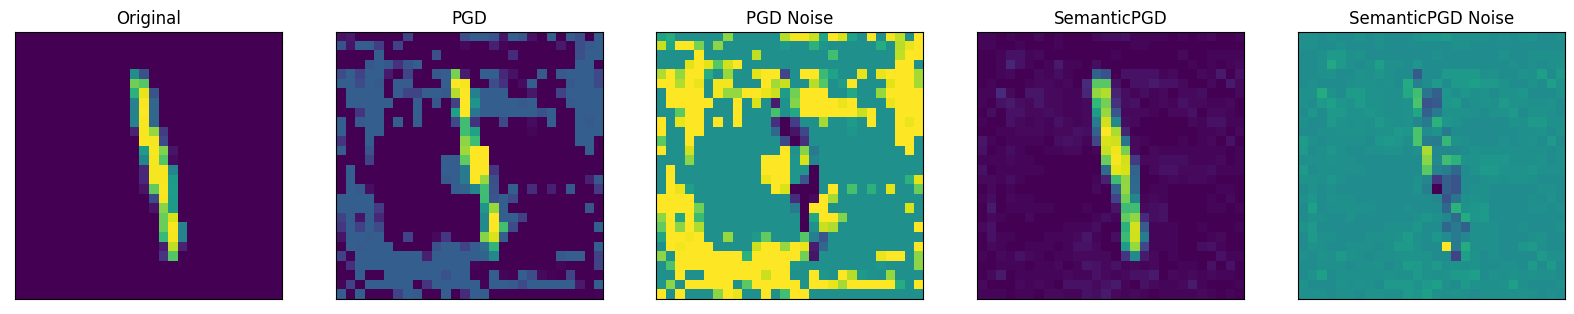

In [208]:
pgd_correct = 0
spgd_correct = 0
total = 0
for i, (images, labels) in enumerate(valid_dataloader):
    labels = labels.to(args.device)
    images = images.to(args.device)

    pgd_adv_images = pgd_attack(classifier_model, images, labels)
    spgd_adv_images = semantic_pgd_attack(classifier_model, autoencoder_model, images, labels)
    
    pgd_outputs = classifier_model(pgd_adv_images)
    spgd_outputs = classifier_model(spgd_adv_images)
    
    _, pgd_pre = torch.max(pgd_outputs.data, 1)
    _, spgd_pre = torch.max(spgd_outputs.data, 1)

    total += 1
    pgd_correct += (pgd_pre == labels).sum()
    spgd_correct += (spgd_pre == labels).sum()
    if i == 10:
        break
    
    # plt.imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(pgd_correct) / (total)))
print('Accuracy of test text: %f %%' % (100 * float(spgd_correct) / (total)))

plot_adversarial_images(images, pgd_adv_images, spgd_adv_images)